In [169]:
import sys
sys.path.insert(0, '/Users/jaredperez/Documents/computer_vision/')
import matplotlib.pyplot as plt
from farkenbach_utils import Utils
f_utils = Utils()
from raft_utils import Utils
r_utils = Utils()
from model_utils import *
import torch
from CNN import miniNet, Inference
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import median_filter
sys.path.insert(0, '/Users/jaredperez/Documents/computer_vision/training_set_building/app_training_set/')
from grid_utils import Utils
g_utils = Utils()
import scipy
from scipy.signal import find_peaks



In [318]:
flows = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/flows.npy')

In [319]:
flows.shape

(79, 480, 680, 2)

# Grids and Trajectories

In [320]:
grid_points = g_utils.devlop_grid_points(flows, grid_size=8, max_length=15, drift_threshold=10)
trajectories = g_utils.process_trajectory_vectors(grid_points)

In [321]:
grid_points=np.stack(grid_points)

In [322]:
grid_points.shape

(79, 60, 85, 2)

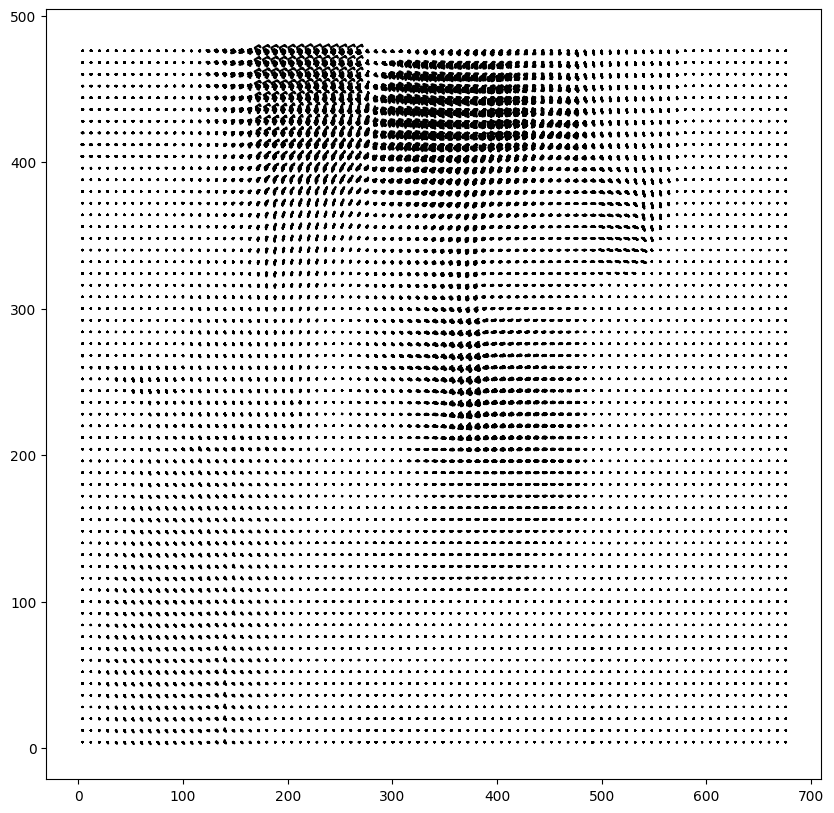

In [323]:
fig, ax = plt.subplots(figsize=(10,10))
grid_y, grid_x = grid_points.shape[1:3]

for i in range(grid_y):
    for j in range(grid_x):
        x_coords = grid_points[:,i,j,1]
        y_coords = grid_points[:,i,j,0]

        ax.plot(x_coords, y_coords, color='black')

plt.show()

In [8]:
## These are my displacement vectors
trajectories

array([[[[-4.30812007e-03,  5.68896132e-03],
         [ 5.79058830e-03,  1.73604644e-02],
         [ 5.51088749e-03,  1.38912892e-02],
         ...,
         [ 9.01248823e-03,  3.86338430e-02],
         [ 8.86156793e-03,  5.97862566e-02],
         [ 8.50101284e-03,  5.80322710e-02]],

        [[ 9.20141646e-03,  1.63890193e-02],
         [ 1.71211472e-02,  2.66434689e-02],
         [ 1.77402432e-02,  1.75241755e-02],
         ...,
         [ 7.47490380e-03,  3.19981857e-02],
         [ 7.17017874e-03,  5.03011088e-02],
         [ 6.72323564e-03,  5.11246142e-02]],

        [[-6.36318606e-03,  4.44522596e-04],
         [ 4.57473965e-03,  1.46536900e-02],
         [ 6.99705617e-03,  7.49666966e-03],
         ...,
         [ 4.74887499e-03,  2.32894175e-02],
         [ 4.47341475e-03,  3.97893211e-02],
         [ 4.03929797e-03,  3.86874366e-02]],

        ...,

        [[-5.24385135e-02, -3.45266737e-02],
         [-4.74846167e-02, -2.83158783e-02],
         [-3.08865601e-02, -3.07450887

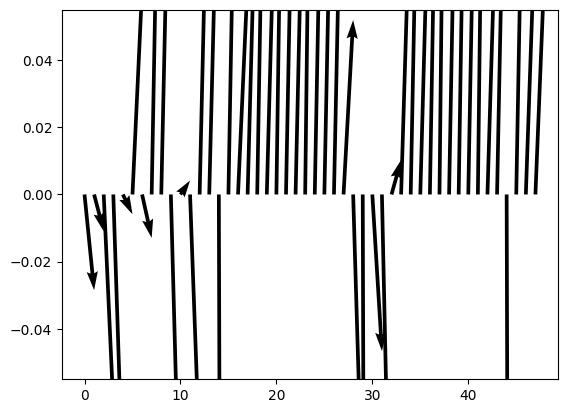

In [9]:
x_values = np.arange(trajectories.shape[0])

# y-values (displacements)
y_values = np.cumsum(trajectories[:, 11,12, 1])

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the vectors
ax.quiver(x_values[:-1], np.zeros_like(x_values[:-1]), np.ones_like(x_values[:-1]), y_values[:-1], angles='xy', scale_units='xy', scale=1)

# Show the plot
plt.show()

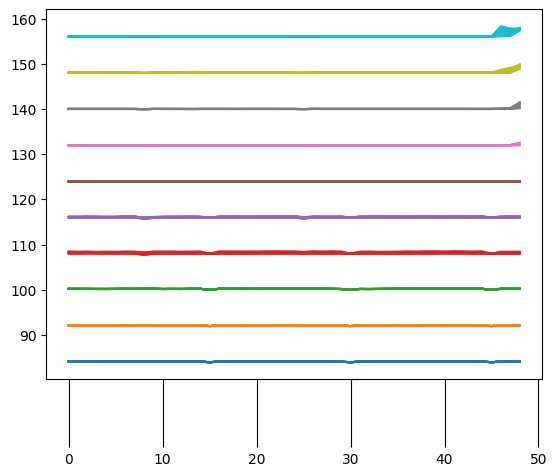

In [10]:
frames = trajectories.shape[0]
points =5
start = 10
end = 20

traj = grid_points

direction = 1

fig, ax = plt.subplots()

for i in range(start, end):
    for j in range(start, end):
        y_coords = traj[:frames, i, j, direction]
        x_coords = np.arange(len(y_coords))

        ax.plot(x_coords, y_coords)

plt.tick_params('x', length = frames)
plt.show()


# Clustering of Keypoints

In [15]:
trajectories.shape

(84, 60, 85, 2)

In [16]:
from feature_functions import PreProcessing

pp = PreProcessing()

matrix = pp.phase_based_similarity_score(trajectories)

In [17]:
matrix

array([[1.        , 0.32142857, 0.25      , ..., 0.03571429, 0.01190476,
        0.03571429],
       [0.32142857, 1.        , 0.4047619 , ..., 0.01190476, 0.03571429,
        0.02380952],
       [0.25      , 0.4047619 , 1.        , ..., 0.02380952, 0.02380952,
        0.02380952],
       ...,
       [0.03571429, 0.01190476, 0.02380952, ..., 1.        , 0.60714286,
        0.36904762],
       [0.01190476, 0.03571429, 0.02380952, ..., 0.60714286, 1.        ,
        0.39285714],
       [0.03571429, 0.02380952, 0.02380952, ..., 0.36904762, 0.39285714,
        1.        ]])

In [18]:
n_components, labels = pp.connected_graphs(matrix)

In [19]:
labels=labels.reshape(trajectories.shape[1],trajectories.shape[2])

In [20]:
n_components

1351

In [21]:
labels

array([[   0,    1,    2, ...,   36,   36,   37],
       [  38,   39,   40, ...,   65,   65,   66],
       [  67,   68,   69, ...,   89,   89,   90],
       ...,
       [1323, 1323, 1323, ..., 1321, 1321, 1321],
       [1323, 1323, 1323, ..., 1321, 1321, 1321],
       [1323, 1323, 1323, ..., 1321, 1321, 1350]], dtype=int32)

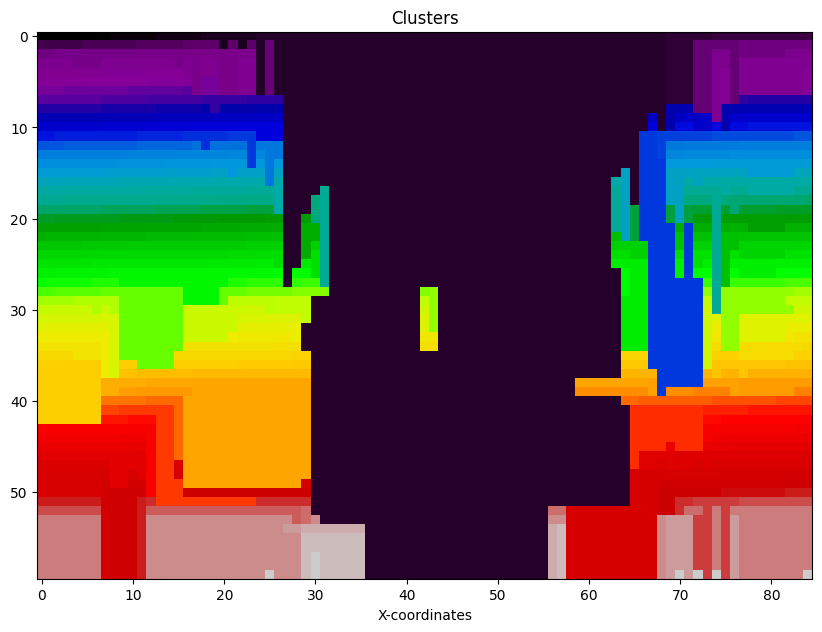

In [22]:
def plot_clusters(clustered_labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_labels, cmap='nipy_spectral')
    plt.title('Clusters')
    plt.xlabel('X-coordinates')
    plt.ylabel
    plt.show()

plot_clusters(labels)

In [21]:
unique_labels, counts = np.unique(labels, return_counts=True)

### Testing Batch Approach

In [27]:
def compute_phase_difference(traj1, traj2):
        phase1 = np.arctan2(traj1[..., 1], traj1[..., 0])
        phase2 = np.arctan2(traj2[..., 1], traj2[..., 0])

        phasediff = np.abs(phase1 - phase2)
        return phasediff


def batch_phase_based_similarity_score(data, threshold=5, chunk_size=500):
        n_samples, n_x, n_y = data.shape[0], data.shape[1], data.shape[2]
        num_points = n_x * n_y
        matrix = np.zeros((num_points, num_points))

        data_full = data.reshape(n_samples, num_points, 2)

        for start in range(0, num_points, chunk_size):
            end = min(start + chunk_size, num_points)

            data_i = data_full[:, start:end].reshape(n_samples, end - start,1, 2)
            data_j = data_full.reshape(n_samples, 1, num_points, 2)

            phase_diff = compute_phase_difference(data_i, data_j)

            sim_scores_chunk = np.mean(phase_diff < np.radians(threshold), axis=0)

            matrix[start:end, :] = sim_scores_chunk
        
        return matrix

In [28]:
matrix = batch_phase_based_similarity_score(trajectories)

In [30]:
n_components, labels = pp.connected_graphs(matrix)
labels=labels.reshape(trajectories.shape[1],trajectories.shape[2])
print(n_components)
labels

1351


array([[   0,    1,    2, ...,   36,   36,   37],
       [  38,   39,   40, ...,   65,   65,   66],
       [  67,   68,   69, ...,   89,   89,   90],
       ...,
       [1323, 1323, 1323, ..., 1321, 1321, 1321],
       [1323, 1323, 1323, ..., 1321, 1321, 1321],
       [1323, 1323, 1323, ..., 1321, 1321, 1350]], dtype=int32)

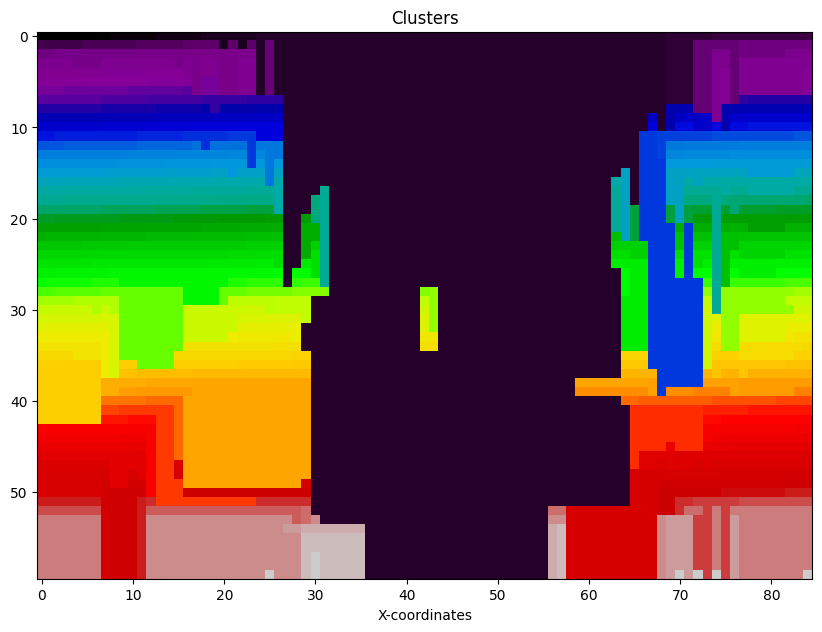

In [31]:
def plot_clusters(clustered_labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_labels, cmap='nipy_spectral')
    plt.title('Clusters')
    plt.xlabel('X-coordinates')
    plt.ylabel
    plt.show()

plot_clusters(labels)

### Trying same approach with Numba

In [32]:
from numba import jit

class TrajectoryNumba:

    @staticmethod
    @jit(nopython=True)
    def compute_phase_difference(traj1, traj2):
        phase1 = np.arctan2(traj1[..., 1], traj1[..., 0])
        phase2 = np.arctan2(traj2[..., 1], traj2[..., 0])
        phasediff = np.abs(phase1 - phase2)
        return phasediff

    @staticmethod
    @jit(nopython=True)
    def batch_phase_based_similarity_score(data, threshold=5, chunk_size=500):
        n_samples, n_x, n_y = data.shape[0], data.shape[1], data.shape[2]
        num_points = n_x * n_y
        matrix = np.zeros((num_points, num_points))

        data_full = data.reshape(n_samples, num_points, 2)

        for start in range(0, num_points, chunk_size):
            end = min(start + chunk_size, num_points)

            data_i = data_full[:, start:end].reshape(n_samples, end - start,1, 2)
            data_j = data_full.reshape(n_samples, 1, num_points, 2)

            phase_diff = TrajectoryNumba.compute_phase_difference(data_i, data_j)

            sim_scores_chunk = np.mean(phase_diff < np.radians(threshold), axis=0)

            matrix[start:end, :] = sim_scores_chunk
        
        return matrix



ImportError: Numba needs NumPy 1.24 or less

In [34]:
np.version.version

'1.25.0'

# Frequency Features

In [11]:
flows[2]==flows[1]

array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]]])

In [12]:
trajectories.shape

(49, 60, 85, 2)

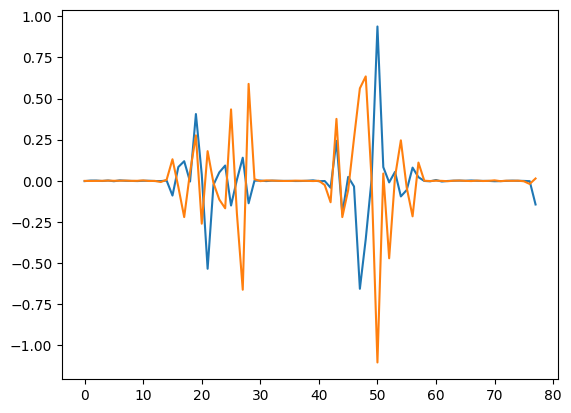

In [324]:
whole_signal = trajectories[:, 11, 20, :]
plt.plot(whole_signal)

In [316]:
concentric_y_peaks, _=find_peaks(-trajectories[:,13,20,1], height=0.6, distance=15)
eccentric_y_peaks, _=find_peaks(trajectories[:,13,20,1], height=0.6, distance=15)

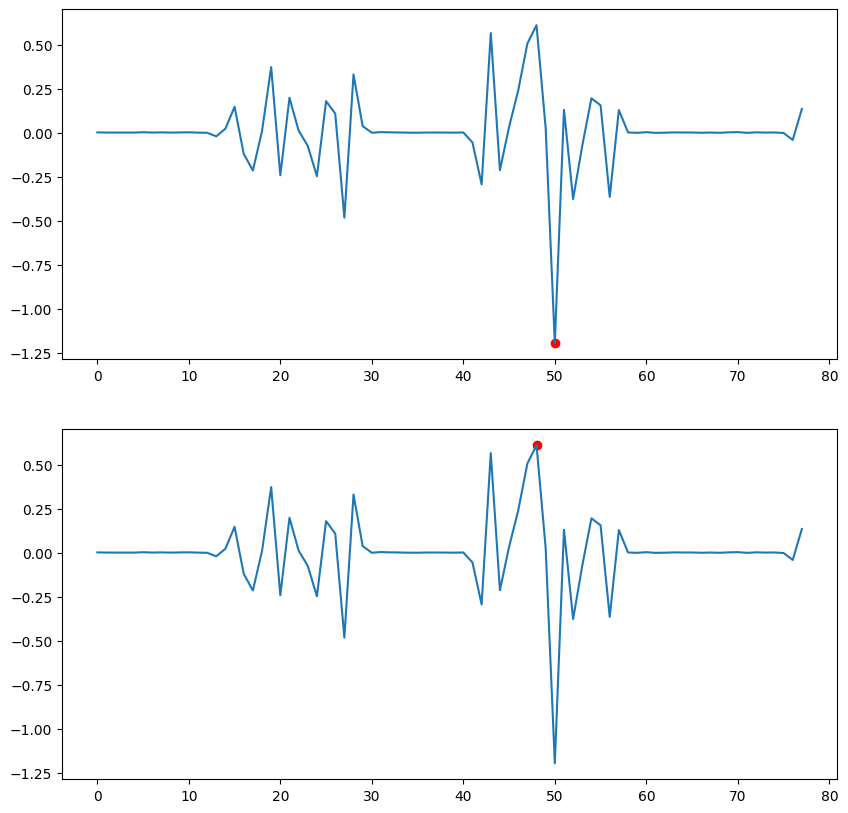

In [317]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(trajectories[:,13,20,1])
ax[0].scatter(concentric_y_peaks, trajectories[:,13,20,1][concentric_y_peaks], color='red')
ax[1].plot(trajectories[:,13,20,1])
ax[1].scatter(eccentric_y_peaks, trajectories[:,13,20,1][eccentric_y_peaks], color='red')

In [15]:
magnitudes = np.linalg.norm(trajectories[:, 13, 11, :])

In [18]:
trajectories[:, 13, 11, 1]

array([-1.72454885e-02, -1.37323116e-02,  3.59582834e-02, -2.17377167e-02,
        1.81229316e-02,  1.90209722e-02,  3.41311095e-02, -4.14526929e-02,
        1.66725726e-02,  4.45196559e-01,  1.63656415e-01, -6.29098990e-01,
        1.35098393e-02,  3.14065790e-02, -6.39855739e-02,  7.57673355e-02,
       -7.28926675e-02,  2.15423269e-02, -1.62212942e-02,  4.98027638e-03,
       -4.31300711e-02, -2.90959325e-02, -5.46398400e-03,  1.58953418e-02,
        1.99119493e-03,  1.32567478e-02, -3.15130199e-02,  2.23179502e-02,
        3.12248694e-02,  1.13409262e-02,  3.23822819e-02,  8.26746101e-02,
        5.21147901e-02,  1.31465913e+00, -1.40687323e+00, -6.16496899e-02,
       -3.98171165e-02, -3.06924757e-02,  5.70572218e-02,  2.06105032e-02,
        1.35497169e-02,  2.72502087e-02, -1.24806784e-02,  1.13572299e-02,
       -6.01425060e-02,  5.73360545e-02,  3.35727889e-02,  1.74390711e-02,
       -4.04447750e-02, -7.88531839e-03, -3.78726396e-02,  2.04485276e-02,
        4.37566971e-02,  

In [15]:
grid_points.shape

(54, 60, 85, 2)

In [16]:
test_flow = flows[0]
print(test_flow.shape)

(480, 680, 2)


In [26]:
def devlop_grid_points(flow_batch, grid_size=8, max_length=15, drift_threshold=10):
    #Takes in inputs that have been reshaped by 
    W, H = flow_batch.shape[1], flow_batch.shape[0]
    start_points = np.mgrid[grid_size//2:H:grid_size, grid_size//2:W:grid_size].transpose(1,2,0)
    start_points = np.minimum(start_points, np.array([H-1, W-1]))

    return start_points

In [27]:
deved = devlop_grid_points(flows[0])

In [29]:
deved.shape

(60, 85, 2)

In [33]:
trajectories[0].shape

(60, 85, 2)

In [57]:
def process_trajectory_vectors(trajectory, start_points):
    displacement = trajectory - start_points

    magnitude = np.linalg.norm(displacement, axis=-1)
    sum_of_magnitudes = magnitude if magnitude.sum() != 0 else 1

    # return displacement, magnitude, sum_of_magnitudes
    norm_vector = displacement / sum_of_magnitudes[..., np.newaxis]

    # Prune static and erratic trajectories
    if np.any(np.abs(norm_vector) <= 0.7):
        return norm_vector * 10
    else:
        return None

In [59]:
res = process_trajectory_vectors(trajectories[0], deved)

In [60]:
res.shape

(60, 85, 2)

In [48]:
norm_y_v = disp[:,:,1]/magnitude

In [50]:
norm_x_v.shape

(60, 85)

In [61]:
test = np.stack((norm_x_v, norm_y_v), axis=2)

In [64]:
test[0]

array([[-0.69795757, -0.71613911],
       [-0.31072608, -0.9504995 ],
       [-0.1918279 , -0.98142858],
       [-0.13801386, -0.9904303 ],
       [-0.10787276, -0.99416471],
       [-0.08822808, -0.9961003 ],
       [-0.07486587, -0.99719361],
       [-0.06504767, -0.99788216],
       [-0.05756177, -0.99834195],
       [-0.05157315, -0.99866922],
       [-0.04662594, -0.99891242],
       [-0.04266039, -0.99908963],
       [-0.03914781, -0.99923343],
       [-0.03634938, -0.99933914],
       [-0.03401768, -0.99942123],
       [-0.03195506, -0.99948931],
       [-0.03007614, -0.99954761],
       [-0.02845356, -0.99959512],
       [-0.02689893, -0.99963816],
       [-0.02556624, -0.99967313],
       [-0.02429235, -0.9997049 ],
       [-0.02317505, -0.99973142],
       [-0.02215277, -0.9997546 ],
       [-0.0212156 , -0.99977492],
       [-0.02035172, -0.99979288],
       [-0.01955441, -0.99980879],
       [-0.01881723, -0.99982294],
       [-0.01813426, -0.99983556],
       [-0.0174958 ,

In [65]:
res[0]

array([[-6.97957569, -7.16139115],
       [-3.10726077, -9.50499503],
       [-1.91827895, -9.8142858 ],
       [-1.38013855, -9.90430298],
       [-1.07872757, -9.94164709],
       [-0.88228076, -9.961003  ],
       [-0.74865874, -9.97193613],
       [-0.65047673, -9.97882157],
       [-0.57561773, -9.98341947],
       [-0.51573151, -9.9866922 ],
       [-0.46625943, -9.98912419],
       [-0.42660386, -9.99089631],
       [-0.39147813, -9.99233431],
       [-0.36349381, -9.99339143],
       [-0.34017682, -9.99421231],
       [-0.31955064, -9.99489307],
       [-0.30076139, -9.99547611],
       [-0.28453564, -9.99595115],
       [-0.26898928, -9.99638158],
       [-0.25566244, -9.9967313 ],
       [-0.24292349, -9.99704897],
       [-0.23175049, -9.99731422],
       [-0.22152771, -9.99754597],
       [-0.21215597, -9.99774924],
       [-0.20351721, -9.99792882],
       [-0.19554407, -9.99808794],
       [-0.18817226, -9.9982294 ],
       [-0.18134259, -9.99835561],
       [-0.174958  ,

### Debugging Live Stream Trajectories

In [469]:
live_traj = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/trajectories.npy')
live_grid = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/grid_points.npy')

In [470]:
live_grid.shape

(81, 48, 68, 2)

In [471]:
live_traj.shape

(80, 2)

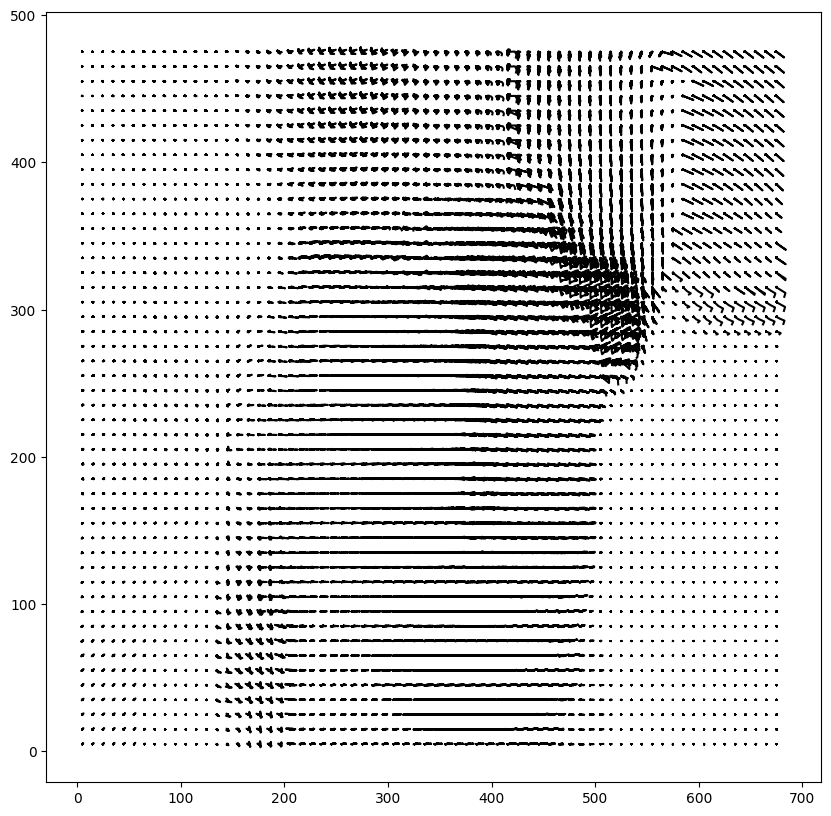

In [438]:
fig, ax = plt.subplots(figsize=(10,10))
grid_y, grid_x = live_grid.shape[1:3]

for i in range(grid_y):
    for j in range(grid_x):
        x_coords = live_grid[:,i,j,1]
        y_coords = live_grid[:,i,j,0]

        ax.plot(x_coords, y_coords, color='black')

plt.show()

### Live grid looks fine, so problem is likely in the trajectory calculation

In [439]:
live_traj_test = g_utils.process_trajectory_vectors(live_grid)

In [440]:
live_traj_test.shape

(80, 48, 68, 2)

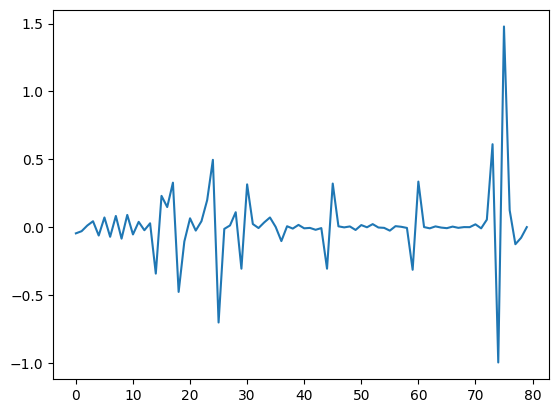

In [441]:
plt.plot(live_traj_test[:, 11,20, 1]) #POST PROCESSING

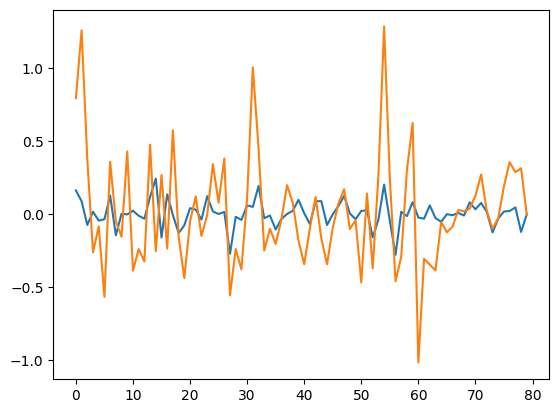

In [472]:
plt.plot(live_traj) #Live proc?essing

In [456]:
test=live_traj[0, :,:, :]
test.shape

(48, 68, 2)

In [458]:
np.mean(test, axis=(0,1))[1]

1.7629865289594733

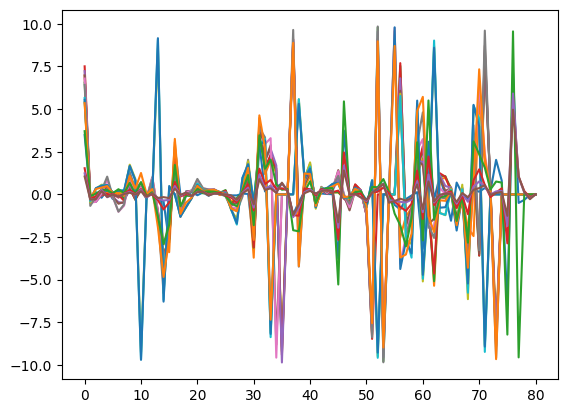

In [455]:
plt.plot(live_traj[:, range(0,live_traj.shape[1],3), 40, 1])

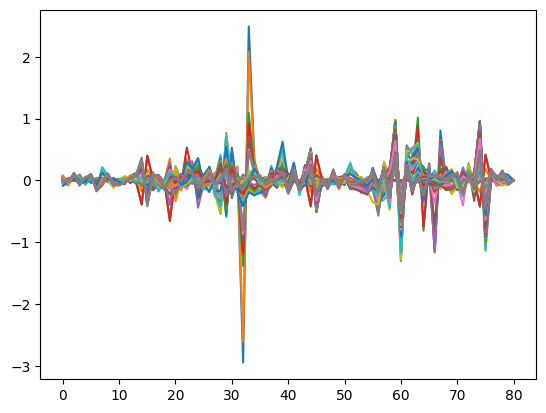

In [395]:
plt.plot(live_traj_test[:, 11, :, 1])

In [196]:
live_traj.shape

(81, 24, 34, 2)

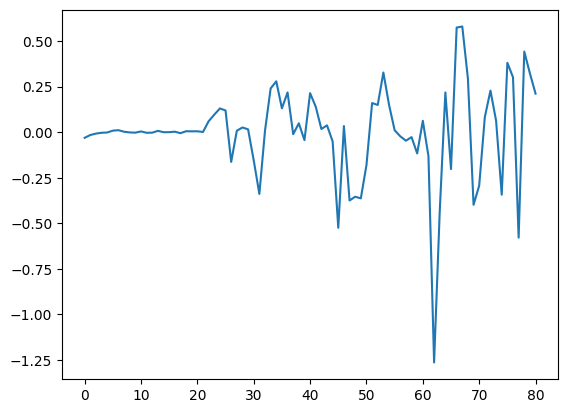

In [207]:
avg_data=np.mean(live_traj[:,11,:,1], axis=1)
plt.plot(avg_data)


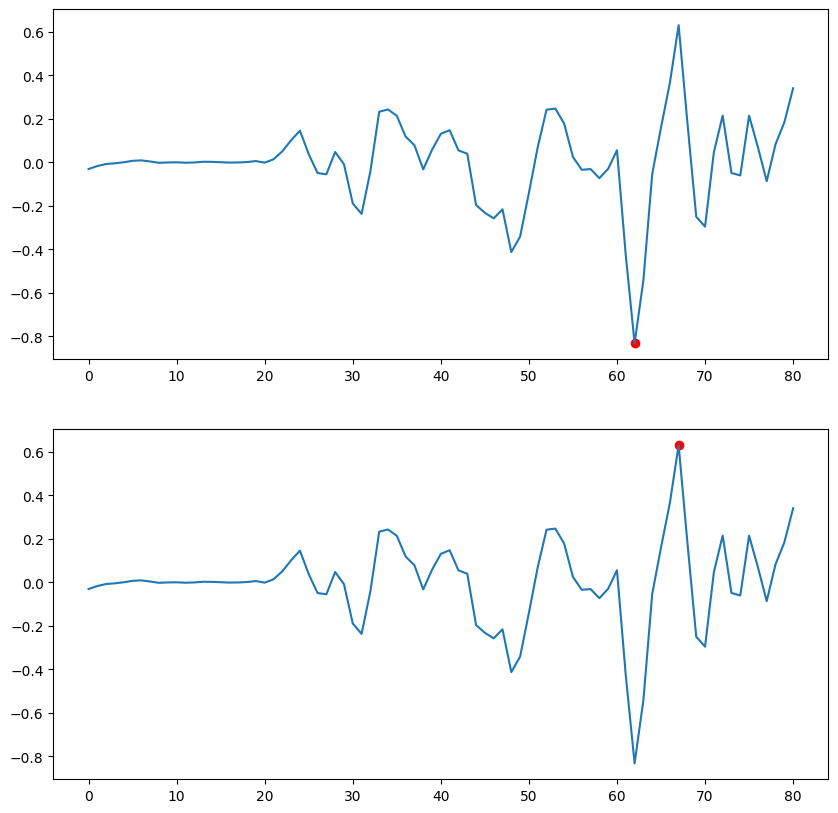

In [217]:
smoothed_grid=savgol_filter(avg_data, window_length=5, polyorder=2)
smoothed_con_peaks, _ = find_peaks(-smoothed_grid, height=0.5, distance=15, prominence=0.5)
smoothed_ecc_peaks, _ = find_peaks(smoothed_grid, height=0.5, distance=15, prominence=0.5)

fig, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(smoothed_grid)
ax[0].scatter(smoothed_con_peaks, smoothed_grid[smoothed_con_peaks], color='red')
ax[1].plot(smoothed_grid)
ax[1].scatter(smoothed_ecc_peaks, smoothed_grid[smoothed_ecc_peaks], color='red')

In [33]:
live_traj.shape

(51, 60, 85, 2)

In [34]:
live_traj_test.shape

(50, 60, 85, 2)

In [420]:
con_live_peaks = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/concentric_peaks.npy')
ecc_live_peaks = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/eccentric_peaks.npy')

In [421]:
ecc_live_peaks+1

array([], dtype=float64)

In [422]:
con_live_peaks

array([], dtype=float64)

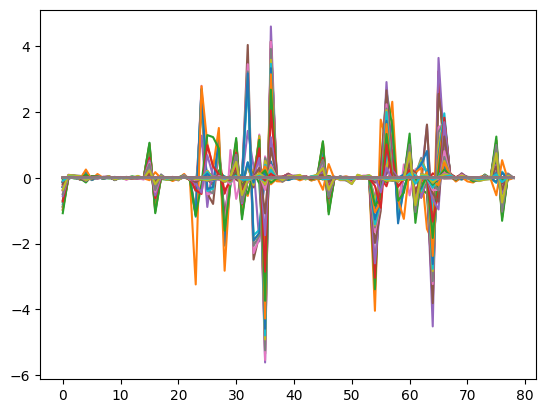

In [367]:
plt.plot(live_traj[:, 11,:, 1])
# plt.scatter(con_live_peaks, live_traj[:, 11,20, 1][con_live_peaks], color='red')
# plt.scatter(ecc_live_peaks, live_traj[:, 11,20, 1][ecc_live_peaks], color='red')

In [405]:
concentric_y_peaks = con_live_peaks
eccentric_y_peaks = ecc_live_peaks

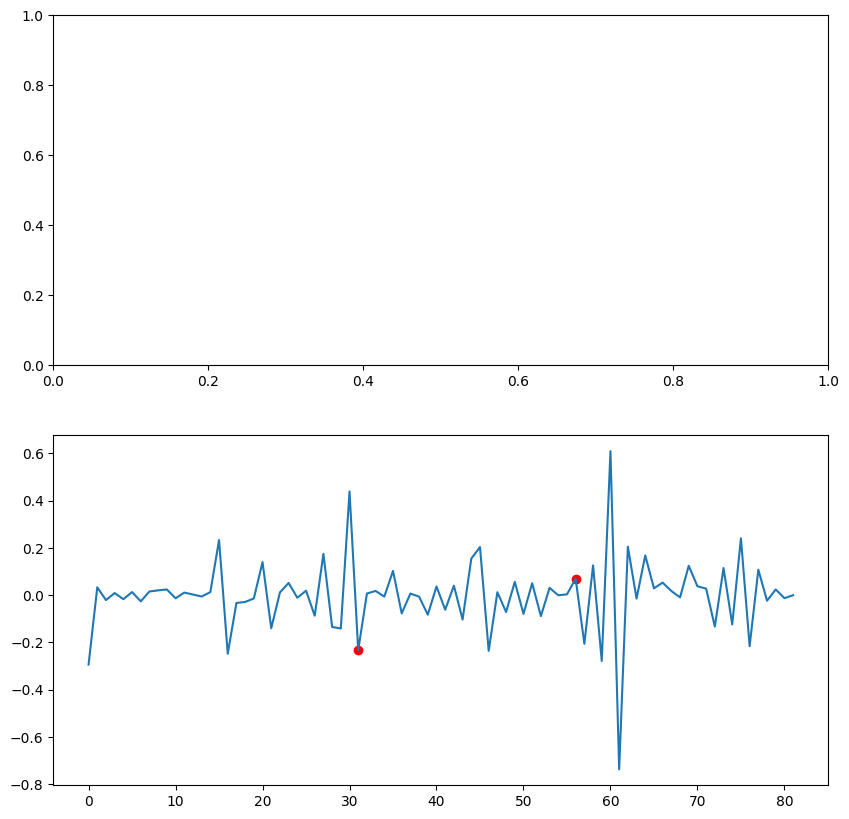

In [406]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

# ax[0].plot(live_traj[:,11,20,1])
# ax[0].scatter(concentric_y_peaks, live_traj[:,11,20,1][concentric_y_peaks], color='red')
ax[1].plot(live_traj[:,11,20,1])
ax[1].scatter(eccentric_y_peaks, live_traj[:,11,20,1][eccentric_y_peaks], color='red')

In [545]:
concentric_y_peaks_live, _ = find_peaks(-live_traj[:,1], height=1, distance=15, prominence=0.5)
eccentric_y_peaks_live, _ = find_peaks(live_traj[:,1], height=1, distance=15, prominence=0.5)

concentric_y_peaks_live = concentric_y_peaks_live 
eccentric_y_peaks_live = eccentric_y_peaks_live 


print(concentric_y_peaks_live)
print(eccentric_y_peaks_live)

[ 15  30  45  60  75  90 105 132]
[ 31  46  61  76  91 106 121]


## Home Stretch

In [1773]:
live_traj = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/trajectories.npy')
live_grid = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/grid_points.npy')

In [1774]:
print(live_grid.shape)
print(live_traj.shape)

(131, 60, 85, 2)
(131, 2)


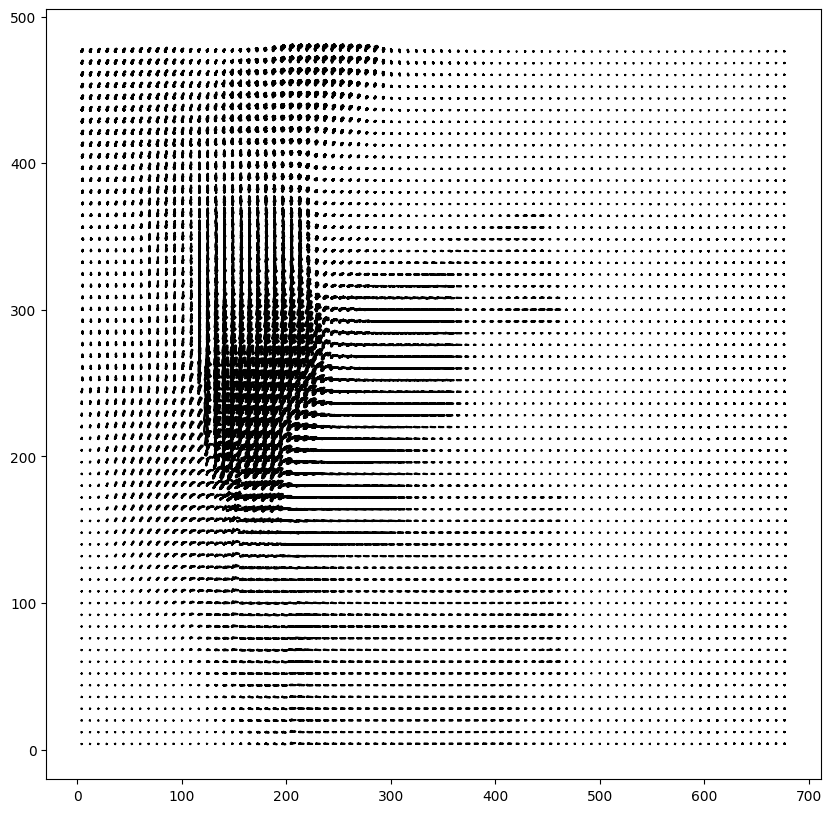

In [1775]:
fig, ax = plt.subplots(figsize=(10,10))
grid_y, grid_x = live_grid.shape[1:3]

for i in range(grid_y):
    for j in range(grid_x):
        x_coords = live_grid[:,i,j,1]
        y_coords = live_grid[:,i,j,0]

        ax.plot(x_coords, y_coords, color='black')

plt.show()

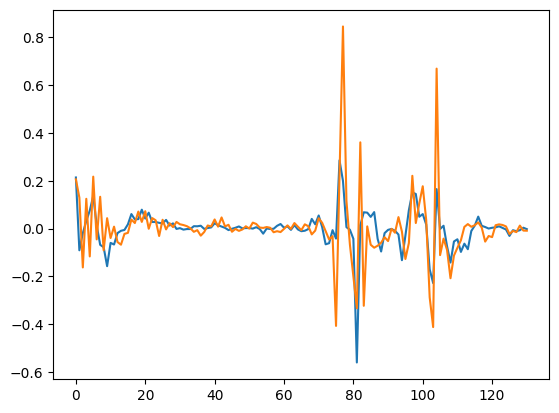

In [1776]:
plt.plot(live_traj) #Live proc?essing

In [1764]:
from scipy.signal import butter, filtfilt

def butter_highpass(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff/nyq
    print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y=filtfilt(b, a, data)
    return y

def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, (low, high), btype='band', analog=False)
    y = filtfilt(b, a, data)  # Using filtfilt to ensure no phase shift
    return y

def butter_lowpass(data, cutoff, fs, order=7):
    nyq = 0.8 * fs
    normal_cutoff = cutoff/nyq
    print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y=filtfilt(b, a, data)
    return y


fs = 30
cutoff = 6
lowcut = 0.1
highcut = 0.5

filtered_y = butter_highpass(live_traj[:,1], cutoff, fs)
# filtered_y = butter_lowpass(live_traj[:,0], cutoff, fs)

0.4


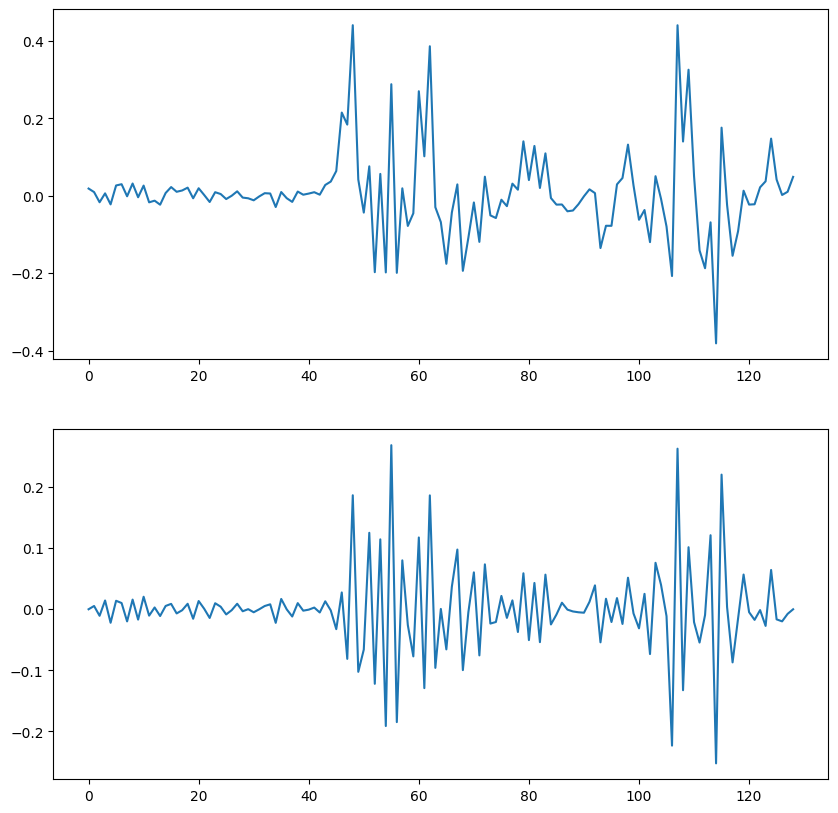

In [1765]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

ax[0].plot(live_traj[:,1])
ax[1].plot(filtered_y)

In [1770]:
thresholds[40:60]

array([-0.02931607,  0.03569558, -0.04655855,  0.01418442,  0.01430506,
       -0.02007449,  0.10660447, -0.08020716, -0.00087032,  0.01868499,
       -0.03742912,  0.02505737, -0.04584843,  0.11111295, -0.08253841,
        0.04366169, -0.05562622, -0.02525897,  0.05704479, -0.03573856])

In [1751]:
extended_window = np.load("/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/extned_window.npy")

In [1686]:
len(extended_window)

15

In [1663]:
new = live_traj[:,1]

In [1705]:
t=new[:30]
np.mean(t)

0.4490057498917161

In [1704]:
sum(t)/len(t)

0.4490057498917161

In [1658]:
print(live_traj[:15])
print(live_traj[15:30])

[[0.44408006 0.50285604]
 [0.48174842 0.46670841]
 [0.47611131 0.46372714]
 [0.47756051 0.47429275]
 [0.47235625 0.47023524]
 [0.47232984 0.47427832]
 [0.47034673 0.47396139]
 [0.46728708 0.4622376 ]
 [0.47198468 0.48079824]
 [0.4745174  0.46052027]
 [0.45537605 0.45800946]
 [0.45894652 0.4442979 ]
 [0.46466327 0.44729586]
 [0.45642246 0.45261307]
 [0.4611972  0.43530655]]
[[0.4633339  0.4464156 ]
 [0.45475689 0.45030336]
 [0.45743092 0.45045115]
 [0.45635789 0.44775309]
 [0.44831266 0.4403147 ]
 [0.45802283 0.45208669]
 [0.45301908 0.45058607]
 [0.45385349 0.45916848]
 [0.45694481 0.46633373]
 [0.45511908 0.46993843]
 [0.38432427 0.40505981]
 [0.38597523 0.38041043]
 [0.38789442 0.3984079 ]
 [0.37985323 0.3929331 ]
 [0.3799823  0.39287174]]


In [1660]:
buff = 15
for i in range(0, len(live_traj), buff):
    new = live_traj[i:buff]
    print(new)

[[0.44408006 0.50285604]
 [0.48174842 0.46670841]
 [0.47611131 0.46372714]
 [0.47756051 0.47429275]
 [0.47235625 0.47023524]
 [0.47232984 0.47427832]
 [0.47034673 0.47396139]
 [0.46728708 0.4622376 ]
 [0.47198468 0.48079824]
 [0.4745174  0.46052027]
 [0.45537605 0.45800946]
 [0.45894652 0.4442979 ]
 [0.46466327 0.44729586]
 [0.45642246 0.45261307]
 [0.4611972  0.43530655]]
[]
[]
[]
[]
[]
[]
[]


In [1767]:
thresholds = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/thresholds.npy')
data_buffers = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/data_buffers.npy')

In [1652]:
thresholds.max()

0.04343882096086216

In [1653]:
print(len(thresholds))
print(len(data_buffers))
print(len(live_traj))

102
102
117


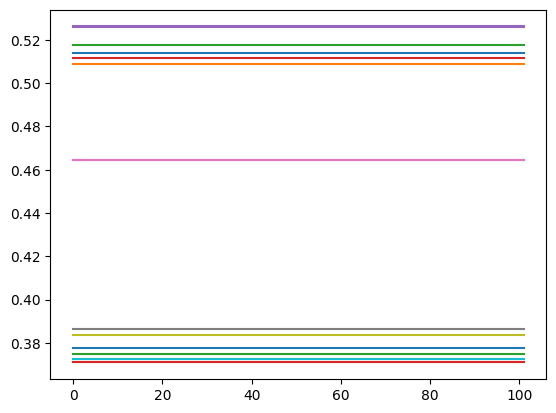

In [1731]:
plt.plot(data_buffers[:,:])

In [1570]:
1.5*6.979739761159287e-08

1.046960964173893e-07

In [1539]:
np.mean(data_buffers[-1])

-0.00477707406663897

In [1540]:
1.5*np.mean(data_buffers[-1,:])

-0.007165611099958454

In [1549]:
thresholds

array([1.87015672e-07, 1.35744224e-07, 2.29862533e-07, 1.42080879e-06,
       3.66262294e-06, 4.25825563e-06, 2.20965763e-06, 3.83128128e-06,
       4.15191528e-06, 3.36706019e-06, 4.11739799e-06, 3.99167583e-06,
       4.15854374e-06, 4.11789133e-06, 4.21443133e-06, 4.57446177e-06,
       4.79802567e-06, 5.18816635e-06, 5.13392525e-06, 4.67371372e-06,
       4.52710164e-06, 5.46821350e-06, 4.90674715e-06, 4.66896151e-06,
       5.27992869e-06, 4.81143492e-06, 5.06908037e-06, 4.87918252e-06,
       4.96806257e-06, 5.05401686e-06, 4.88272350e-06, 5.02569739e-06,
       4.96187527e-06, 4.97837060e-06, 5.08841350e-06, 5.17981286e-06,
       5.21799295e-06, 5.18642801e-06, 5.42666015e-06, 5.34138626e-06,
       5.45500538e-06, 5.32657342e-06, 5.48483667e-06, 5.61636494e-06,
       5.51070901e-06, 5.66026367e-06, 5.61588125e-06, 5.74494060e-06,
       5.77617482e-06, 5.66265768e-06, 5.50992480e-06, 5.63608731e-06,
       5.59249093e-06, 5.46707891e-06, 5.64523072e-06, 5.51401324e-06,
      

[ 54 114]
[ 55 107]


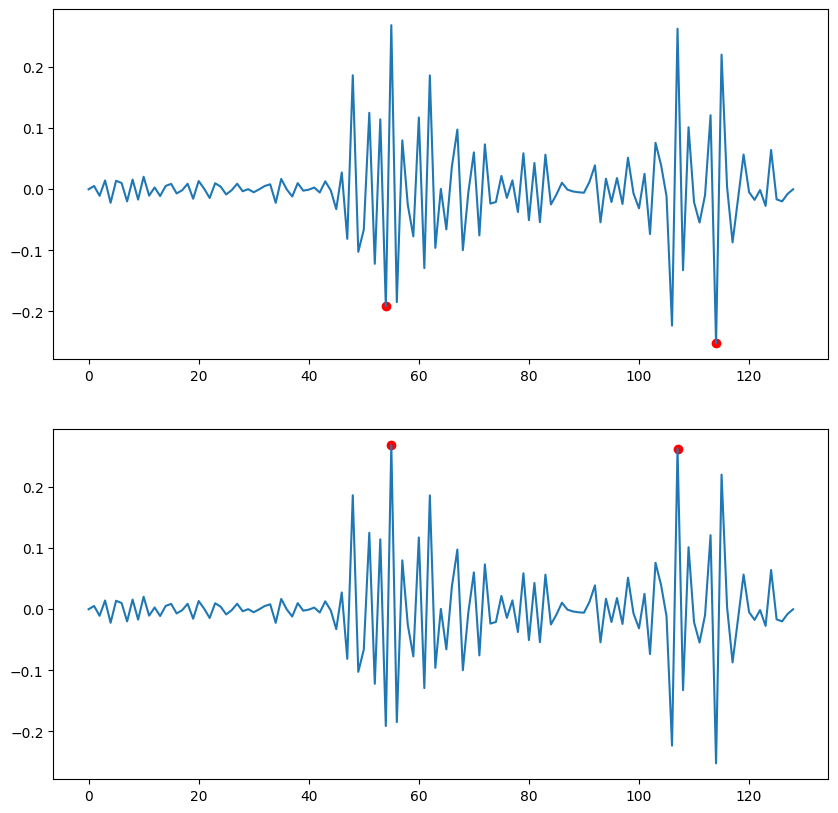

In [1772]:
concentric_y_peaks_live, _ = find_peaks(-filtered_y, height=.003, distance=25, prominence=.3)
eccentric_y_peaks_live, _ = find_peaks(filtered_y, height=.003, distance=25, prominence=.3)

concentric_y_peaks_live = concentric_y_peaks_live 
eccentric_y_peaks_live = eccentric_y_peaks_live 


print(concentric_y_peaks_live)
print(eccentric_y_peaks_live)

fig, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(filtered_y)
ax[0].scatter(concentric_y_peaks_live, filtered_y[concentric_y_peaks_live], color='red')
ax[1].plot(filtered_y)
ax[1].scatter(eccentric_y_peaks_live, filtered_y[eccentric_y_peaks_live], color='red')

In [1384]:
con_live_peaks = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/concentric_peaks.npy')
ecc_live_peaks = np.load('/Users/jaredperez/Documents/webcam_app/myproject/computer-vision/data_pipeline/eccentric_peaks.npy')

print(con_live_peaks)
print(ecc_live_peaks)

[57]
[58]


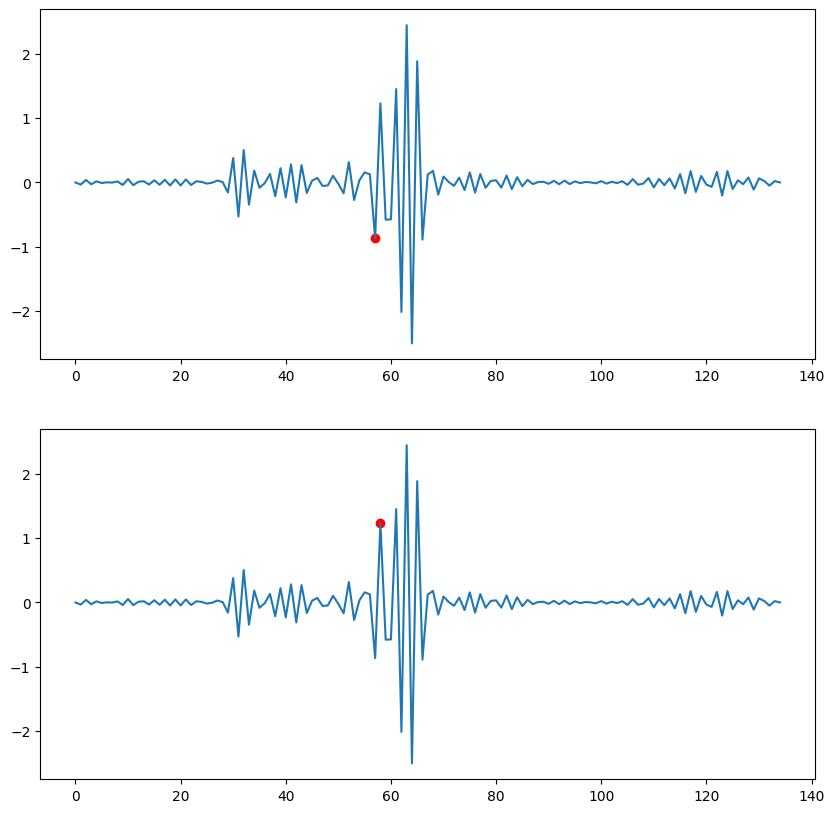

In [1385]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(filtered_y)
ax[0].scatter(con_live_peaks, filtered_y[con_live_peaks], color='red')
ax[1].plot(filtered_y)
ax[1].scatter(ecc_live_peaks, filtered_y[ecc_live_peaks], color='red')